In [9]:
import pandas as pd
import numpy as np

import os
from PIL import Image
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

import matplotlib.pyplot as plt
import torchvision
import random

import torch.optim as optim

import torch
import torch.nn as nn

In [29]:
class FlatImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

folder1 = 'photo_jpg'
folder2 = 'monet_jpg'
folder3 = 'photo_tfrec'
folder4 = 'monet_tfrec'

dataset1 = FlatImageFolder(folder1, transform=transform)
dataset2 = FlatImageFolder(folder2, transform=transform)

class TFRecordImageDataset(Dataset):
    def __init__(self, tfrecord_dir, transform=None):
        self.tfrecord_files = [
            os.path.join(tfrecord_dir, f)
            for f in os.listdir(tfrecord_dir)
            if f.endswith('.tfrec')
        ]
        self.transform = transform
        self.feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
        }
        # Count total records and store (file_idx, record_idx) pairs
        self.index_map = []
        for file_idx, tfrec_file in enumerate(self.tfrecord_files):
            count = sum(1 for _ in tf.data.TFRecordDataset(tfrec_file))
            self.index_map.extend([(file_idx, i) for i in range(count)])

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        file_idx, record_idx = self.index_map[idx]
        tfrec_file = self.tfrecord_files[file_idx]
        # Get the record at record_idx in tfrec_file
        dataset = tf.data.TFRecordDataset([tfrec_file])
        for i, raw_record in enumerate(dataset):
            if i == record_idx:
                example = tf.io.parse_single_example(raw_record, self.feature_description)
                img_bytes = example['image'].numpy()
                img = tf.image.decode_jpeg(img_bytes, channels=3)
                img = tf.image.resize(img, [256, 256])
                img = tf.cast(img, tf.uint8).numpy()
                from PIL import Image
                img = Image.fromarray(img)
                if self.transform:
                    img = self.transform(img)
                return img
        raise IndexError("Index out of range")


dataset3 = TFRecordImageDataset(folder3, transform=transform)
dataset4 = TFRecordImageDataset(folder4, transform=transform)

#   For visualizing
combined_dataset = ConcatDataset([dataset1, dataset2, dataset3, dataset4])
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True, num_workers=4)

photo_dataset = ConcatDataset([dataset1,dataset3])
monet_dataset = ConcatDataset([dataset2,dataset4])

photo_loader = DataLoader(photo_dataset, batch_size=1, shuffle=True, num_workers=4)
monet_loader = DataLoader(monet_dataset, batch_size=1, shuffle=True, num_workers=4)


In [30]:
print(len(combined_dataset))
for i in range(10):
    sample = combined_dataset[i]
    # If your sample is an image tensor:
    print(f"Sample {i} shape: {sample.shape}")

14676
Sample 0 shape: torch.Size([3, 256, 256])
Sample 1 shape: torch.Size([3, 256, 256])
Sample 2 shape: torch.Size([3, 256, 256])
Sample 3 shape: torch.Size([3, 256, 256])
Sample 4 shape: torch.Size([3, 256, 256])
Sample 5 shape: torch.Size([3, 256, 256])
Sample 6 shape: torch.Size([3, 256, 256])
Sample 7 shape: torch.Size([3, 256, 256])
Sample 8 shape: torch.Size([3, 256, 256])
Sample 9 shape: torch.Size([3, 256, 256])


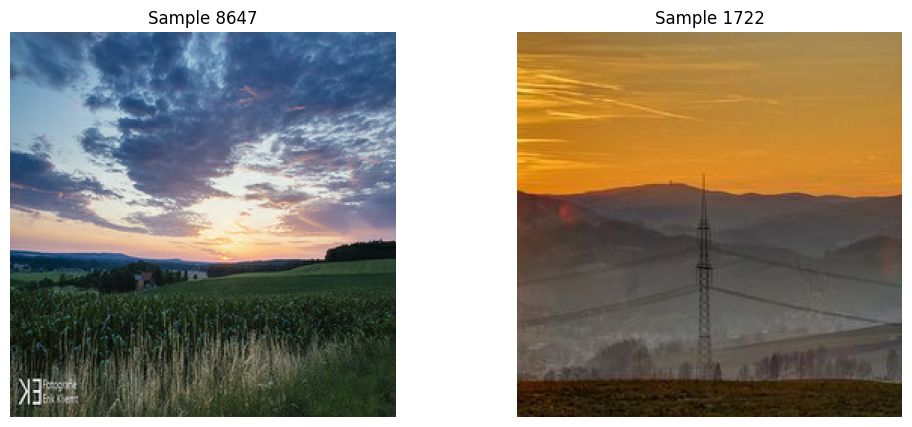

In [31]:
def plot_images(images, titles=None):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 5))
    if len(images) == 1:
        axes = [axes]
    for i, img_tensor in enumerate(images):
        img = torchvision.transforms.ToPILImage()(img_tensor)
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles:
            axes[i].set_title(titles[i])
    plt.show()

# 2 Random Images
idx1 = random.randint(0, len(combined_dataset) - 1)
idx2 = random.randint(0, len(combined_dataset) - 1)
sample1 = combined_dataset[idx1]
sample2 = combined_dataset[idx2]

plot_images([sample1, sample2], titles=[f'Sample {idx1}', f'Sample {idx2}'])


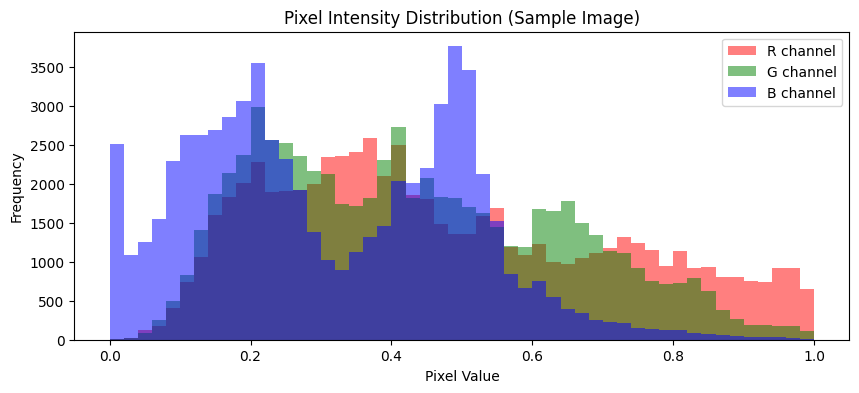

In [32]:
img_tensor = combined_dataset[0]
img_np = img_tensor.numpy()

plt.figure(figsize=(10, 4))
for i, color in enumerate(['r', 'g', 'b']):
    plt.hist(img_np[i].flatten(), bins=50, color=color, alpha=0.5, label=f'{color.upper()} channel')
plt.legend()
plt.title("Pixel Intensity Distribution (Sample Image)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [35]:
# CycleGAN
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=6):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        ]
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(256)]
        model += [
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        model = [
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, padding=1)
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

optimizer_G = optim.Adam(list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [37]:
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

In [38]:
num_epochs = 2

for epoch in range(num_epochs):
    monet_iter = iter(monet_loader)
    for i, photo in enumerate(photo_loader):
        try:
            monet = next(monet_iter)
        except StopIteration:
            monet_iter = iter(monet_loader)
            monet = next(monet_iter)

        real_A = photo.to(device)
        real_B = monet.to(device)

        optimizer_G.zero_grad()
        # id loss
        same_B = G_A2B(real_B)
        loss_identity_B = identity_loss(same_B, real_B) * 5.0
        same_A = G_B2A(real_A)
        loss_identity_A = identity_loss(same_A, real_A) * 5.0
        # GAN loss
        fake_B = G_A2B(real_A)
        pred_fake_B = D_B(fake_B)
        loss_GAN_A2B = adversarial_loss(pred_fake_B, torch.ones_like(pred_fake_B))
        fake_A = G_B2A(real_B)
        pred_fake_A = D_A(fake_A)
        loss_GAN_B2A = adversarial_loss(pred_fake_A, torch.ones_like(pred_fake_A))
        # cycle los
        rec_A = G_B2A(fake_B)
        loss_cycle_A = cycle_loss(rec_A, real_A) * 10.0
        rec_B = G_A2B(fake_A)
        loss_cycle_B = cycle_loss(rec_B, real_B) * 10.0

        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_A + loss_cycle_B
        loss_G.backward()
        optimizer_G.step()

        optimizer_D_A.zero_grad()
        pred_real_A = D_A(real_A)
        loss_D_real_A = adversarial_loss(pred_real_A, torch.ones_like(pred_real_A))
        pred_fake_A = D_A(fake_A.detach())
        loss_D_fake_A = adversarial_loss(pred_fake_A, torch.zeros_like(pred_fake_A))
        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        optimizer_D_B.zero_grad()
        pred_real_B = D_B(real_B)
        loss_D_real_B = adversarial_loss(pred_real_B, torch.ones_like(pred_real_B))
        pred_fake_B = D_B(fake_B.detach())
        loss_D_fake_B = adversarial_loss(pred_fake_B, torch.zeros_like(pred_fake_B))
        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}] "
                  f"Loss_G: {loss_G.item():.4f} Loss_D_A: {loss_D_A.item():.4f} Loss_D_B: {loss_D_B.item():.4f}")


Epoch [1/2] Batch [0] Loss_G: 18.6296 Loss_D_A: 0.4408 Loss_D_B: 0.8548
Epoch [1/2] Batch [100] Loss_G: 7.4750 Loss_D_A: 0.2506 Loss_D_B: 0.2381
Epoch [1/2] Batch [200] Loss_G: 4.3889 Loss_D_A: 0.4219 Loss_D_B: 0.1708
Epoch [1/2] Batch [300] Loss_G: 4.8841 Loss_D_A: 0.2443 Loss_D_B: 0.2587
Epoch [1/2] Batch [400] Loss_G: 5.1653 Loss_D_A: 0.1840 Loss_D_B: 0.1054
Epoch [1/2] Batch [500] Loss_G: 5.3622 Loss_D_A: 0.1411 Loss_D_B: 0.1704
Epoch [1/2] Batch [600] Loss_G: 5.2034 Loss_D_A: 0.2406 Loss_D_B: 0.2481
Epoch [1/2] Batch [700] Loss_G: 4.2946 Loss_D_A: 0.3050 Loss_D_B: 0.2315
Epoch [1/2] Batch [800] Loss_G: 5.6152 Loss_D_A: 0.2400 Loss_D_B: 0.1711
Epoch [1/2] Batch [900] Loss_G: 5.0576 Loss_D_A: 0.3342 Loss_D_B: 0.3610
Epoch [1/2] Batch [1000] Loss_G: 3.4959 Loss_D_A: 0.3970 Loss_D_B: 0.2363
Epoch [1/2] Batch [1100] Loss_G: 3.9873 Loss_D_A: 0.2079 Loss_D_B: 0.1231
Epoch [1/2] Batch [1200] Loss_G: 5.8360 Loss_D_A: 0.2547 Loss_D_B: 0.2034
Epoch [1/2] Batch [1300] Loss_G: 4.0740 Loss_D_A:

KeyboardInterrupt: 